# Problem

* Wikipedia metinleri içeren veri setine metin ön işleme ve görselleştirme yapınız.

# Görev-1: Metin Ön İşleme

> * **Adım 1:** Metin ön işleme için clean_text adında fonksiyon oluşturunuz. Fonksiyon;  
>> * Büyük küçük harf dönüşümü, 
>> * Noktalama işaretlerini çıkarma, 
>> * Numerik ifadeleri çıkarma Işlemlerini gerçekleştirmeli.

In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
def clean_text(df, col_name, islower=True):
    if islower:
        df[col_name] = df[col_name].str.lower()
    else:
        df[col_name] = df[col_name].str.upper()
        
    df[col_name] = df[col_name].str.replace("[^\w\s]", "") # Noktalama işaretleri
    df[col_name] = df[col_name].str.replace("\d", "") # Numerik İfadeler

> * **Adım 2:** Yazdığınız fonksiyonu veri seti içerisindeki tüm metinlere uygulayınız.

In [3]:
df = pd.read_csv("datasets/wiki_data.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,text
0,Anovo\n\nAnovo (formerly A Novo) is a computer...
1,Battery indicator\n\nA battery indicator (also...
2,"Bob Pease\n\nRobert Allen Pease (August 22, 19..."
3,CAVNET\n\nCAVNET was a secure military forum w...
4,CLidar\n\nThe CLidar is a scientific instrumen...


In [4]:
# "text" kolonu için fonksiyonu uyguluyorum.

clean_text(df, "text")

df.head()

,text
0,anovo\n\nanovo formerly a novo is a computer s...
1,battery indicator\n\na battery indicator also ...
2,bob pease\n\nrobert allen pease august â â ju...
3,cavnet\n\ncavnet was a secure military forum w...
4,clidar\n\nthe clidar is a scientific instrumen...


> * **Adım 3:**  Metin içinde öznitelik çıkarımı yaparken önemli olmayan kelimeleri çıkaracak remove_stopwords adında fonksiyon yazınız.

In [5]:
def remove_stopwords(df, col_name):
    
    sw = stopwords.words("english")
    
    df[col_name] = df[col_name].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
    
# Farklı dillerdeki stopwordsler olacağı için belki "sw" değişkenini fonksiyona parametre olarak göndermek mantıklı olabilir.    

> * **Adım 4:** Yazdığınız fonksiyonu veri seti içerisindeki tüm metinlere uygulayınız.

In [6]:
remove_stopwords(df, "text")

df.head()

,text
0,anovo anovo formerly novo computer services co...
1,battery indicator battery indicator also known...
2,bob pease robert allen pease august â â june a...
3,cavnet cavnet secure military forum became ope...
4,clidar clidar scientific instrument used measu...


> * **Adım 5:**  Metinde az geçen (1000'den az, 2000'den az gibi) kelimeleri bulunuz. Ve bu kelimeleri metin içerisinden çıkartınız. 

In [7]:
def frequency(df, col_name, threshold=2):
    temp_df = pd.Series(" ".join(df[col_name]).split()).value_counts()
    drops = temp_df[temp_df < threshold] # Default=2. Yani 1 defa geçen kelimelerden kurtuluyoruz.
    df[col_name] = df[col_name].apply(lambda x: " ".join(x for x in x.split() if x not in drops))
    
    # Frekansa göre kelimeleri drop ederken bazı kayıtları tamamen kaybediyoruz. Bu yüzden bu boş satırları drop ediyorum.
    df.drop(df[df[col_name] == ""].index, axis=0, inplace=True) 

frequency(df, "text", 1001) # 1001'den az geçen kelimeleri 
df.head()

,text
0,computer services company based france founded...
1,battery battery also known battery device info...
2,august â â june analog integrated circuit desi...
3,military became april part allows access knowl...
4,scientific instrument used lower camera turn l...


> * **Adım 6:** Metinleri tokenize edip sonuçları gözlemleyiniz. 

In [8]:
# DF üzerinde değişiklik yapmıyoruz. Sadece bilgilendirme amaçlı bir fonksiyon
def tokenization(df, col_name, limit=5):
    
    print(df[col_name].apply(lambda x: TextBlob(x).words).head(limit))

tokenization(df, "text")

0    [computer, services, company, based, france, f...
1    [battery, battery, also, known, battery, devic...
2    [august, â, â, june, analog, integrated, circu...
3    [military, became, april, part, allows, access...
4    [scientific, instrument, used, lower, camera, ...
Name: text, dtype: object


> * **Adım 7:**  Lemmatization işlemi yapınız.

In [9]:
# Lemmatization: Kelimeleri köklerine indirgeme
def lemmatization(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

lemmatization(df, "text")
df.head()

,text
0,computer service company based france founded ...
1,battery battery also known battery device info...
2,august â â june analog integrated circuit desi...
3,military became april part allows access knowl...
4,scientific instrument used lower camera turn l...


# Görev-2: Metin Görselleştirme

> * **Adım 1:** Metindeki terimlerin frekanslarını hesaplayınız. 

In [10]:
# Satır bazında ilgili kelimelerin frekanslarını çıkartıyorum.

tf = df["text"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.head()

,words,tf
0,service,8201.00
1,company,13806.00
2,computer,6879.00
3,based,5614.00
4,france,1161.00


> * **Adım 2:** Bir önceki adımda bulduğunuz terim frekanslarının Barplot grafiğini oluşturunuz. 

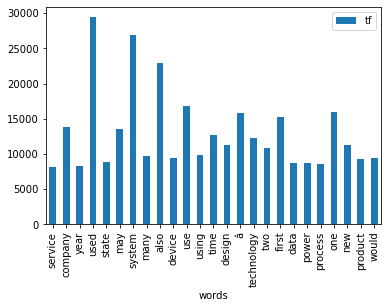

In [11]:
# tf değişkeninin 8000'den çok olanlarına barplot uyguluyorum.

tf[tf["tf"] > 8000].plot.bar(x="words", y="tf")
plt.show()
# En çok geçen kelimeler; "used" - "system" - "also" vb.
# also --> Neden stopwords değil acaba?
# â --> anlamsız bir kelime drop edebiliriz.

> * **Adım 3:** Kelimeleri WordCloud ile görselleştiriniz. 

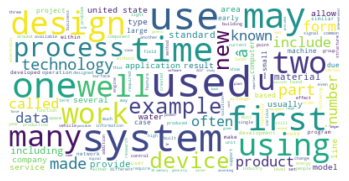

In [12]:
# Tüm datayı tek bir text haline dönüştürdük.
text = " ".join(i for i in df.text)

wordcloud = WordCloud(max_font_size=50,
                      max_words=200,
                      background_color="white").generate(text)

plt.imshow(wordcloud, interpolation="bilinear") # Frekanslara göre kelime boyutları artıyor.
plt.axis("off")
plt.show()

# Görev-3: Tüm Aşamaları için Tek Bir Fonksiyon

> * **Adım 1:**  Metin ön işleme işlemlerini gerçekleştiriniz. 

> * **Adım 2:** Görselleştirme işlemlerini fonksiyona argüman olarak ekleyiniz. 

> * **Adım 3:**  Fonksiyonu açıklayan 'docstring' yazınız.

In [16]:
def text_preprocessing(df, col_name, islower=True, threshold=2, limit=5, plot=True, bar_th=8000):
    """
    Veri setindeki metin sütunu üzerinde gerekli metin ön işleme adımlarını ve görselleştirmeleri yapar.
    
    Parameters
    ----------
    df: dataframe
        üzerinde işlem yapacağımız "string" sütunu alacağımız dataframe'dir.
    col_name: str
        df içerisinde ön işleme ve görselleştirmeler yapılacak sütun adı.
    islower: bool
        "df" içerisindeki "col_name" sütununun hangi kalıba (Büyük Harf, Küçük Harf) getirileceğini ifade eder.
    threshold: int
        "df" içerisindeki "col_name" sütunundan atılacak kelimelerin eşik değerini belirtir.
    limit: int
        "df" içerisinden ekrana getirilecek değişken sayısı.
    plot: bool
        Görselleştirmenin yapılmasına karar veren değişken.
    bar_th: int
        Bar plot için filtreleme eşik değeri.
    
    Returns
    -------
    df.head(limit)
            df içerisinden ilk limit kadar satır.
    df[col_name].apply(lambda x: TextBlob(x).words).head(limit)
            df içerisindeki "col_name" değişkeninin tokenization işlemi uygulanmış hali
    
    """
    
    
    print("Verimizin İlk Hali;")
    print(df.head(limit))
    print("#"*30)
    print("\n\n")
    
    if islower:
        df[col_name] = df[col_name].str.lower()
    else:
        df[col_name] = df[col_name].str.upper()
        
    df[col_name] = df[col_name].str.replace("[^\w\s]", "") # Noktalama işaretleri
    df[col_name] = df[col_name].str.replace("\d", "") # Numerik İfadeler
    
    # Farklı dillerdeki stopwordsler olacağı için belki "sw" değişkenini fonksiyona parametre olarak göndermek mantıklı olabilir.
    sw = stopwords.words("english")
    
    # stopwords
    df[col_name] = df[col_name].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
    
    temp_df = pd.Series(" ".join(df[col_name]).split()).value_counts()
    drops = temp_df[temp_df < threshold] # Default=2. Yani 1 defa geçen kelimelerden kurtuluyoruz.
    df[col_name] = df[col_name].apply(lambda x: " ".join(x for x in x.split() if x not in drops))
    
    # Frekansa göre kelimeleri drop ederken bazı kayıtları tamamen kaybediyoruz. Bu yüzden bu boş satırları drop ediyorum.
    df.drop(df[df[col_name] == ""].index, axis=0, inplace=True)
    
    print("Cümlelerin tokenization edilmiş hali;\n")
    print(df[col_name].apply(lambda x: TextBlob(x).words).head(limit)) # Sadece gözlem amaçlı
    print("#"*30)
    print("\n\n")
    
    # Lemmatization
    df[col_name] = df[col_name].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    
    print("Verimizin Son Hali;")
    print(df.head(limit))
    print("#"*30)
    print("\n\n")
    
    # Görselleştirme
    if plot:
        
        # Barplot
        tf = df[col_name].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
        tf.columns = ["words", "tf"]
        tf[tf["tf"] > bar_th].plot.bar(x="words", y="tf")
        plt.show()
        
        # WordCloud
        text = " ".join(i for i in df[col_name])

        wordcloud = WordCloud(max_font_size=50,
                              max_words=100,
                              background_color="white").generate(text)

        plt.imshow(wordcloud, interpolation="bilinear") # Frekanslara göre kelime boyutları artıyor.
        plt.axis("off")
        plt.show()

In [17]:
df = pd.read_csv("datasets/wiki_data.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,text
0,Anovo\n\nAnovo (formerly A Novo) is a computer...
1,Battery indicator\n\nA battery indicator (also...
2,"Bob Pease\n\nRobert Allen Pease (August 22, 19..."
3,CAVNET\n\nCAVNET was a secure military forum w...
4,CLidar\n\nThe CLidar is a scientific instrumen...


Verimizin İlk Hali;
                                                text
0  Anovo\n\nAnovo (formerly A Novo) is a computer...
1  Battery indicator\n\nA battery indicator (also...
2  Bob Pease\n\nRobert Allen Pease (August 22, 19...
3  CAVNET\n\nCAVNET was a secure military forum w...
4  CLidar\n\nThe CLidar is a scientific instrumen...
##############################



Cümlelerin tokenization edilmiş hali;

0    [computer, services, company, based, france, f...
1    [battery, battery, also, known, battery, devic...
2    [august, â, â, june, analog, integrated, circu...
3    [military, became, april, part, allows, access...
4    [scientific, instrument, used, lower, camera, ...
Name: text, dtype: object
##############################



Verimizin Son Hali;
                                                text
0  computer service company based france founded ...
1  battery battery also known battery device info...
2  august â â june analog integrated circuit desi...
3  military became apr

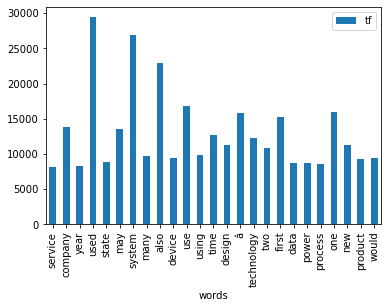

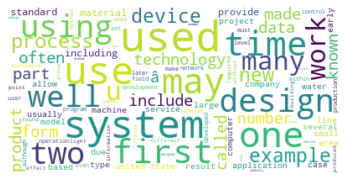

In [18]:
text_preprocessing(df, "text", threshold=1001)